In [216]:
import itertools
import glob
import os
from pathlib import Path

import meshio
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from celluloid import Camera
from IPython.display import HTML, Image

ROOT = Path("./assets/img/")

if not os.path.exists(ROOT):
    os.makedirs(ROOT)

In [2]:
vtk_path = "VTK/cavity_2000.vtk"

mesh = meshio.read(vtk_path)

In [208]:
def plot_heatmap(mesh, field, field_type="point", resolution=(64, 64, 64), ax=None, sigma=0., cmap="inferno"):

    if ax is None:
        ax = plt.subplot()

    ax.set_xticks([])
    ax.set_yticks([])
    
    resx, resy, resz = resolution
    
    points = mesh.points

    if field_type == "cell":
        
        cells = mesh.cells[0].data

        centroids = []
    
        for c in cells:
            cell_vertices = points[c]
    
            centroid = cell_vertices.mean(axis=0)
            centroids.append(centroid)
    
        points = np.array(centroids)
    
    def min_max(arr, index):
        return arr[:,index].min(), arr[:,index].max()
    
    xmin, xmax = min_max(points, 0)
    ymin, ymax = min_max(points, 1)
    zmin, zmax = min_max(points, 2)

    img = np.zeros(resolution)

    tree = sp.spatial.KDTree(points)

    def get_cartesian(idx, res, cmin, cmax):
        return cmin+idx/(res-1)*(cmax-cmin) 

    indices = list(itertools.product(*list(map(lambda x: list(range(x)), resolution))))
    
    for i, j, k in indices:

        x = get_cartesian(i, resx, cmin=xmin, cmax=xmax)
        y = get_cartesian(j, resy, cmin=ymin, cmax=ymax)
        z = get_cartesian(k, resz, cmin=zmin, cmax=zmax)

        point = np.array([x, y, z])
        point_idx = tree.query(point, k=1)[1]

        val = field[point_idx]

        img[i,j,k] = val

    img = img.mean(axis=2)

    if sigma > 0:
        img = sp.ndimage.gaussian_filter(img, sigma=sigma)
    
    ax.imshow(img, cmap=cmap, origin="lower")

    return ax

<Axes: >

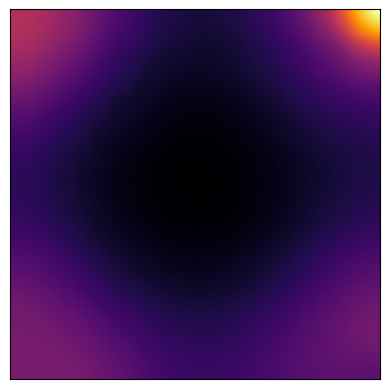

In [209]:
plot_heatmap(mesh=mesh, field=mesh.point_data["p"], resolution=(128, 128, 2), sigma=2.5)

In [206]:
def plot_quiver(mesh, field, field_type="point", ax=None, cmap="bwr"):

    if ax is None:
        ax = plt.subplot()

    ax.set_xticks([])
    ax.set_yticks([])
    
    points = mesh.points

    if field_type == "cell":
        
        cells = mesh.cells[0].data

        centroids = []
    
        for c in cells:
            cell_vertices = points[c]
    
            centroid = cell_vertices.mean(axis=0)
            centroids.append(centroid)
    
        points = np.array(centroids)

    eps = 1e-7
    
    field = field[:,:2]

    norm = np.linalg.norm(field, axis=1, keepdims=True)
    field = field/(norm+eps)

    ax.quiver(points[:,0], points[:,1], field[:,0], field[:,1], np.squeeze(norm, axis=1), cmap=cmap)

    return ax

<Axes: >

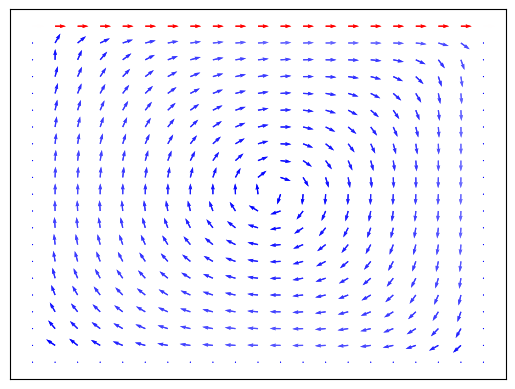

In [207]:
plot_quiver(mesh, field=mesh.point_data["U"])

In [210]:
class MeshGraphics:

    def __init__(self, mesh):
        self.mesh: meshio.Mesh = mesh

    def get_field(self, field_name, field_type):
        
        if field_type == "point":
            field = self.mesh.point_data[field_name]
        elif field_type == "cell":
            field = self.mesh.cell_data[field_name][0]
        return field
    
    def plot_heatmap(self, field_name, field_type, **kwargs):
        field = self.get_field(field_name, field_type=field_type)
        return plot_heatmap(self.mesh, field=field, field_type=field_type, **kwargs)

    def plot_quiver(self, field_name, field_type, **kwargs):
        field = self.get_field(field_name, field_type=field_type)
        return plot_quiver(self.mesh, field=field, field_type=field_type, **kwargs)
        

In [234]:
def animate(vtk_root, plot_fn, gif_path, fps=30):

    vtk_files = glob.glob(os.path.join(vtk_root, "*.vtk"))

    def key(file):
        file = Path(file).stem
        return int(file.split("_")[-1])
    
    vtk_files = sorted(vtk_files, key=key)

    fig, ax = plt.subplots(1, 1)

    camera = Camera(fig)
    
    for file in vtk_files:

        mesh = meshio.read(file)
        plot_fn(mesh, ax)
        
        camera.snap()

    anim = camera.animate()  
    anim.save(gif_path, writer="pillow", fps=fps)
    plt.close()
    
    return Image(url=gif_path)

In [243]:
def plot_fn(mesh, ax):
    mesh = MeshGraphics(mesh)
    mesh.plot_heatmap(field_name="p", field_type="point", resolution=(128, 128, 2), sigma=2.5, ax=ax)

animate("./VTK", plot_fn, gif_path=ROOT / "p_heatmap.gif", fps=10)

In [236]:
def plot_fn(mesh, ax):
    mesh = MeshGraphics(mesh)
    mesh.plot_quiver(field_name="U", field_type="point", ax=ax)

animate("./VTK", plot_fn, gif_path=ROOT / "u_quiver.gif", fps=10)